<a href="https://colab.research.google.com/github/MHoseinHoushmand/Clustering_by_SLFA/blob/main/Clustering_by_SLFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import numpy as np

import pdb
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]
print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


In [32]:
from sklearn.datasets import fetch_20newsgroups

# بارگیری دیتاست 20newsgroups
data_with_names = fetch_20newsgroups()

# نمایش نام دسته‌ها برای هر دیتا
for i in range(len(data_with_names.target)):
    label = data_with_names.target[i]
    print(label)
    category_name = data_with_names.target_names[label]
    print(f"نام دسته‌ی متناظر با دیتا {i+1}: {category_name}")

Streaming output truncated to the last 5000 lines.
7
نام دسته‌ی متناظر با دیتا 8815: rec.autos
6
نام دسته‌ی متناظر با دیتا 8816: misc.forsale
7
نام دسته‌ی متناظر با دیتا 8817: rec.autos
18
نام دسته‌ی متناظر با دیتا 8818: talk.politics.misc
16
نام دسته‌ی متناظر با دیتا 8819: talk.politics.guns
8
نام دسته‌ی متناظر با دیتا 8820: rec.motorcycles
4
نام دسته‌ی متناظر با دیتا 8821: comp.sys.mac.hardware
8
نام دسته‌ی متناظر با دیتا 8822: rec.motorcycles
8
نام دسته‌ی متناظر با دیتا 8823: rec.motorcycles
17
نام دسته‌ی متناظر با دیتا 8824: talk.politics.mideast
11
نام دسته‌ی متناظر با دیتا 8825: sci.crypt
15
نام دسته‌ی متناظر با دیتا 8826: soc.religion.christian
13
نام دسته‌ی متناظر با دیتا 8827: sci.med
3
نام دسته‌ی متناظر با دیتا 8828: comp.sys.ibm.pc.hardware
4
نام دسته‌ی متناظر با دیتا 8829: comp.sys.mac.hardware
10
نام دسته‌ی متناظر با دیتا 8830: rec.sport.hockey
12
نام دسته‌ی متناظر با دیتا 8831: sci.electronics
10
نام دسته‌ی متناظر با دیتا 8832: rec.sport.hockey
5
نام دسته‌ی متناظر با دیتا

In [33]:
print (dataset.data[800],dataset.target_names[dataset.target[800]],dataset.target[800])


Any lunar satellite needs fuel to do regular orbit corrections, and when
its fuel runs out it will crash within months.  The orbits of the Apollo
motherships changed noticeably during lunar missions lasting only a few
days.  It is *possible* that there are stable orbits here and there --
the Moon's gravitational field is poorly mapped -- but we know of none.

Perturbations from Sun and Earth are relatively minor issues at low
altitudes.  The big problem is that the Moon's own gravitational field
is quite lumpy due to the irregular distribution of mass within the Moon. sci.space 2


In [34]:

def docs_as_tfidf(docs):
  vectorizer = TfidfVectorizer(
     max_df=0.5,
     min_df=5,
     stop_words="english",
  )

  docs_vector = vectorizer.fit_transform(docs)
  return docs_vector.toarray()

In [35]:
population_size = 120 # Frogs number
memplex_num = 12 #define as m
memplex_size = 10 #define as n
max_iteration = 50
memplex_iteration = 8
docs = dataset.data
docs_vector = docs_as_tfidf(docs)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
def cosin_sim(a,b):
   return cosine_similarity([a], [b])[0][0]

In [37]:
from numpy.linalg import norm
def SSE(cluster,doc_mean):
  size = len(cluster)
  sse=0
  for doc in cluster:
    sse += cosin_sim(doc,doc_mean)**2
  sse = sse/size
  return sse

In [38]:
from numpy.linalg import norm
def BC(doc_means):
   BC=0
   size = len(doc_means)
   for i in range(size):
      for j in range(i+1,size):
          BC += cosin_sim(doc_means[i],doc_means[j])**2
   return BC

In [39]:
def WC(clusters):
    WC = 0
    for cluster in clusters:
        doc_mean = np.average(cluster, axis=0)
        WC += SSE(cluster,doc_mean)
    return WC

In [40]:
def build_clusters(answer,docs_vector,clusters_size):
   clusters = []
   for i in range(clusters_size):
       clusters.append([])
   for j in range(len(answer)):
       if -1 < answer[j]:
        clusters[answer[j]].append(docs_vector[j])
   return clusters

In [41]:
def fitness(answer,docs_vector,clusters_size):
   doc_means = []
 #  pdb.runcall(build_clusters,answer,docs_vector,clusters_size)
   clusters = build_clusters(answer,docs_vector,clusters_size)
   for i in range(clusters_size):
       doc_means.append(
          np.average(clusters[i], axis=0)
       )
   wc = WC(clusters)
   bc = BC(doc_means)
   fitness = wc/bc
   return fitness

In [42]:
import random
def cross_over(answer_a,answer_b):
    size = len(answer_a)
    output = []
    for i in range(size):
       choice = random.choice([0,1])
       if choice == 0:
          output.append(answer_a[i])
       else:
          output.append(answer_b[i])
    return tuple(output)

In [43]:
def best_and_worst(answers):
     best =  max(answers, key=answers.get)
     worst = min(answers, key=answers.get)
     return tuple(best) , tuple(worst)

In [44]:
def global_best(memplexes):
     local_bests = {}
     for memplex in memplexes:
         local_best =  max(memplex, key=memplex.get)
         local_bests[local_best]= memplex[local_best]
     global_best = max(local_bests, key=local_bests.get)
     return global_best, local_bests[global_best]

In [45]:
def keys_to_remove(keys , dict):
   for k in keys:
      if k in dict:
          dict.pop(k)
   return dict

In [46]:
def mutation(global_best,clusters_size):
    new_ans = list(global_best)
    size = int(len(global_best)/4)
    indexes = np.random.choice(np.arange(0,len(global_best)), size=size, replace=False)
    values= [random.randint(-1, 3) for _ in range(size)]
    for i in range(size):
      new_ans[indexes[i]] = values[i]
    return tuple(new_ans)

In [47]:
def Create_memplexes(population,memplex_num):
     memplexes = []
     keys = list(population.keys())
     population_size = len(population)
     for i in range(memplex_num):
         memplexes.append({})
     for i in range(population_size):
         memplexes[i % memplex_num][keys[i]] = population[keys[i]]
     return memplexes

In [48]:
def shufeling(memplexes):
    output = {}
    for memplex in memplexes:
        output.update(memplex)
    return output

In [49]:
def Trues(g_best):
  true = 0
  size = len(dataset.data)
  for i in range(size):
     if labels[i] == g_best[i]:
        true = true +1
  print(true)

In [55]:
print(list(labels))

[0, 1, 1, 3, 1, 1, 2, 2, 2, 0, 1, 2, 3, 2, 0, 3, 3, 1, 1, 2, 3, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 2, 0, 3, 0, 1, 2, 0, 1, 2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 2, 3, 1, 0, 2, 1, 2, 2, 1, 3, 3, 3, 0, 1, 3, 1, 0, 0, 0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 1, 1, 1, 1, 0, 3, 3, 2, 1, 0, 3, 3, 2, 3, 1, 1, 2, 0, 2, 2, 1, 3, 1, 1, 0, 0, 0, 2, 3, 2, 2, 3, 3, 0, 0, 0, 1, 2, 0, 1, 3, 0, 1, 0, 1, 0, 3, 3, 3, 3, 3, 0, 1, 0, 2, 0, 0, 0, 1, 2, 3, 3, 2, 2, 1, 1, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 2, 3, 1, 2, 3, 0, 0, 3, 2, 1, 0, 3, 1, 2, 0, 2, 2, 3, 2, 3, 2, 1, 2, 3, 3, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 3, 2, 2, 3, 3, 2, 1, 0, 2, 1, 0, 2, 3, 2, 2, 3, 0, 2, 1, 1, 0, 2, 2, 1, 2, 1, 3, 2, 3, 1, 2, 2, 1, 0, 2, 1, 2, 3, 1, 0, 1, 0, 0, 2, 0, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1, 0, 1, 3, 0, 1, 1, 1, 3, 0, 2, 3, 0, 2, 1, 2, 0, 0, 2, 3, 2, 2, 1, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 1, 0, 0, 1, 1, 1, 1, 0, 3, 0, 1, 2, 3, 0, 1, 2, 3, 1, 3, 2, 2, 3, 3, 2, 3, 3, 0, 1, 3, 1, 1, 2, 2, 2, 3, 1, 1, 2, 0, 0, 0, 

In [69]:
import operator
def frog_leaping_search(docs_vector,cluster_size):
     answers=np.random.randint(-1, cluster_size, size=(population_size , len(dataset.data)))
     population = {}
     i=0
     for answer in answers:
       # pdb.runcall(fitness,answer,docs_vector,cluster_size)
        i+=1
        population[tuple(answer)] = fitness(answer,docs_vector,cluster_size)
        print(i,population[tuple(answer)])

     for i in range(max_iteration):
        population = dict( sorted(population.items(), key=operator.itemgetter(1), reverse=True))
   #    pdb.runcall(Create_memplexes,population, memplex_num)
        memplexes = Create_memplexes(population, memplex_num)
        population.clear()
      #  pdb.set_trace()
        for j in range(memplex_num):
            print(i,j,len(memplexes[j]))
            sub_memplex = dict(random.sample(list(memplexes[j].items()),k=5))
            memplexes[j] =  keys_to_remove(sub_memplex.keys(),memplexes[j])
            for k in range(memplex_iteration):
                #pdb.runcall(best_and_worst,sub_memplex)
                ans_best, ans_worst = best_and_worst(sub_memplex)
                ans_out = cross_over(ans_best,ans_worst)
                fitness_out = fitness(ans_out,docs_vector,cluster_size)

              # pdb.runcall(best_and_worst,sub_memplex)
               #print(population[ans_worst],population[ans_out])
                if (sub_memplex[ans_worst]<fitness_out):
                    del sub_memplex[ans_worst]
                    sub_memplex[ans_out] = fitness_out
                else:
                   # pdb.runcall(global_best,memplexes)
                    g_best, g_value = global_best(memplexes)
                    ans_out = cross_over(g_best,ans_worst)
                    fitness_out = fitness(ans_out,docs_vector,cluster_size)
                    if (sub_memplex[ans_worst] < fitness_out):
                        del sub_memplex[ans_worst]
                        sub_memplex[ans_out] = fitness_out
                    else:
                        del sub_memplex[ans_worst]
                     #   pdb.runcall(mutation,g_best,cluster_size)
                        ans_out = mutation(g_best,cluster_size)
                        fitness_out = fitness(ans_out,docs_vector,cluster_size)
                        sub_memplex[ans_out] = fitness_out
        #     pdb.runcall(join_dicts,memplexes[j],sub_memplex)
            memplexes[j].update(sub_memplex)
        g_best, g_value = global_best(memplexes)
        show_result(g_best)
        print(g_value)
        population = shufeling(memplexes)
     return g_best, g_value

In [70]:
g_best, g_value = frog_leaping_search(docs_vector,4)
true = 0
size = len(dataset.data)
print(labels)
print(list(g_best))

1 0.014037294662187928
2 0.014158183967702959
3 0.01426139546990606
4 0.013823344381766635
5 0.014233723816487914
6 0.014116614887545112
7 0.014083369841613808
8 0.014209313845267628
9 0.01391541519298019
10 0.013942317219500814
11 0.013928527882122208
12 0.01401707081430658
13 0.013833800537574147
14 0.014085353130777804
15 0.013954562176194868
16 0.014371439179493324
17 0.014042034685050095
18 0.014041656487928886
19 0.013869373663574587
20 0.014071619172715233
21 0.014178902226797145
22 0.014043360243431224
23 0.01393145315379693
24 0.014065376400114358
25 0.013889344619029605
26 0.013935167320661225
27 0.014090985605046763
28 0.013851246728053608
29 0.013862987966252072
30 0.01407095594130197
31 0.014040057730044596
32 0.01386515999633151
33 0.013997127550737568
34 0.014124597847490504
35 0.01373979379846568
36 0.013961578327241299
37 0.014042961269184499
38 0.014298134424700201
39 0.014062598205703979
40 0.014084296981538305
41 0.013799529992500491
42 0.014208642185269333
43 0.014

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7bc0eb6e6050> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7bc0eb6e52d0> (for post_execute):


KeyboardInterrupt: ignored

In [61]:
print(list(labels))
print(list(g_best))

[0, 1, 1, 3, 1, 1, 2, 2, 2, 0, 1, 2, 3, 2, 0, 3, 3, 1, 1, 2, 3, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 2, 0, 3, 0, 1, 2, 0, 1, 2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 2, 3, 1, 0, 2, 1, 2, 2, 1, 3, 3, 3, 0, 1, 3, 1, 0, 0, 0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 1, 1, 1, 1, 0, 3, 3, 2, 1, 0, 3, 3, 2, 3, 1, 1, 2, 0, 2, 2, 1, 3, 1, 1, 0, 0, 0, 2, 3, 2, 2, 3, 3, 0, 0, 0, 1, 2, 0, 1, 3, 0, 1, 0, 1, 0, 3, 3, 3, 3, 3, 0, 1, 0, 2, 0, 0, 0, 1, 2, 3, 3, 2, 2, 1, 1, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 2, 3, 1, 2, 3, 0, 0, 3, 2, 1, 0, 3, 1, 2, 0, 2, 2, 3, 2, 3, 2, 1, 2, 3, 3, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 3, 2, 2, 3, 3, 2, 1, 0, 2, 1, 0, 2, 3, 2, 2, 3, 0, 2, 1, 1, 0, 2, 2, 1, 2, 1, 3, 2, 3, 1, 2, 2, 1, 0, 2, 1, 2, 3, 1, 0, 1, 0, 0, 2, 0, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1, 0, 1, 3, 0, 1, 1, 1, 3, 0, 2, 3, 0, 2, 1, 2, 0, 0, 2, 3, 2, 2, 1, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 1, 0, 0, 1, 1, 1, 1, 0, 3, 0, 1, 2, 3, 0, 1, 2, 3, 1, 3, 2, 2, 3, 3, 2, 3, 3, 0, 1, 3, 1, 1, 2, 2, 2, 3, 1, 1, 2, 0, 0, 0, 

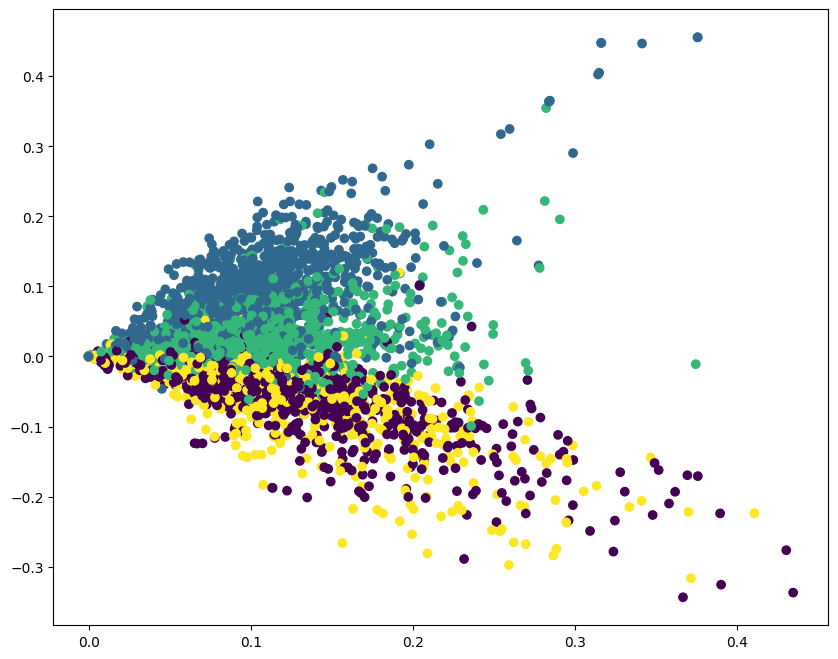

In [66]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt



tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000, stop_words='english')

lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(docs_vector)

plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(labels), cmap='viridis')

In [68]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt



def show_result(g_best):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000, stop_words='english')
    lsa = TruncatedSVD(n_components=2)
    lsa_matrix = lsa.fit_transform(docs_vector)
    plt.figure(figsize=(10, 8))
    plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(g_best), cmap='viridis')